In [7]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline
import os
from sqlalchemy import create_engine
import time
from datetime import datetime, date, time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import scipy.stats as st
import copy
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score

Completed Functions

In [2]:
# CRS_ELAPSED_TIME --> HAUL_LENGTH
def haul(df, col):
    '''Determine if flight length is SHORT, MEDIUM or LONG based on expected elapsed flight time. 
            Input: 
            (0) df containing flight information, 
            (1) column containing the elapsed flight time in minutes   
            Output:   'haul_length' column determining haul length category per row in df'''
    length=[]
    for i in df[col]:
        if i < (3*60): # up to 3 hours
            length.append(0) # 0 = SHORT HAUL
        elif (i >= (3*60)) and (i < (6*60)): # 3-6 hours
            length.append(1) # 1 = MEDIUM HAUL
        elif i >= (6*60):# 6+ hours
            length.append(2) # 2 = LONG HAUL
    df['haul_length'] = length
# example of implementation: haul(flight10k, 'crs_elapsed_time')

# CRS_DEP_TIME (hhmm) --> CRS_DEP_TIME (hh) -- to be used within time_day function
def gethour(df,col):
    '''Convert hhmm to hh (24-hr) hour-only output
            Input: 
            (0) df containing flight information, 
            (1) column containing the hhmm time                  
            Output:   rewrite on input column in rounded hh format'''
    values = []
    for i in df[col]:
        mins = (i % 100) / 60 
        hour = i // 100
        hh = round(hour+mins)
        values.append(hh)
    df[col] = values
# example of implementation: gethour(flight10k, 'crs_dep_time')

# CRS_DEP/ARR_TIME (hhmm) --> hot encoded categorical time of day 'morning, aft...' 
def time_day(df, col):
    ''' Input:
            (0) df containing flight information
            (1) corresponding column of time of flight (i.e. departure or arrival) (format hhmm)
        Output:   rewrite of time column into categorical MORNING, AFTERNOON, EVENING, or OVERNIGHT'''
    gethour(df, col)
    timeday = []
    for i in df[col]:
        if (i>=23) or (i<5):
            timeday.append(0) # 0 = OVERNIGHT
        elif (i>=5) and (i<12):
            timeday.append(1) # 1 = MORNING
        elif (i>=12) and (i<18):
            timeday.append(2) # 2 = AFTERNOON
        elif (i>=18) and (i<23):
            timeday.append(3) # 3 = EVENING
    return timeday
# example of implementation: time_day(flight10k, 'crs_dep_time')

Open CSVs

In [5]:
airline_rating = pd.read_csv('airline_delay_rating.csv', index_col=0)
origin_traffic = pd.read_csv('origin_traffic_rating.csv', index_col=0)
origin_delay = pd.read_csv('origin_delay_rating.csv', index_col=0)
dest_traffic = pd.read_csv('dest_traffic_rating.csv', index_col=0)
delay_dep_h = pd.read_csv('crs_dep_time_delay_rating.csv', index_col=0)
delay_arr_h = pd.read_csv('crs_arr_time_delay_rating.csv', index_col=0)
weather_df = pd.read_csv('weather_df_monthlymean_bins.csv', index_col=0)
flights = pd.read_csv('flights250K.csv', index_col=0)
flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,2018-12-26,DL,DL_CODESHARE,DL,4598,OO,N641CA,4598,13851,OKC,"Oklahoma City, OK",14869,SLC,"Salt Lake City, UT",839,830.0,-9.0,15.0,845.0,945.0,25.0,1028,1010.0,-18.0,0.0,NaN,0.0,N,169.0,160.0,120.0,1.0,866.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-04-18,WN,WN,WN,555,WN,N455WN,555,14831,SJC,"San Jose, CA",14908,SNA,"Santa Ana, CA",1715,1736.0,21.0,9.0,1745.0,1843.0,4.0,1830,1847.0,17.0,0.0,NaN,0.0,N,75.0,71.0,58.0,1.0,342.0,17.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2018-10-30,WN,WN,WN,2294,WN,N7873A,2294,11292,DEN,"Denver, CO",14747,SEA,"Seattle, WA",815,816.0,1.0,17.0,833.0,1004.0,10.0,1020,1014.0,-6.0,0.0,NaN,0.0,N,185.0,178.0,151.0,1.0,1024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-03-09,AA,AA,AA,400,AA,N730US,400,11278,DCA,"Washington, DC",11057,CLT,"Charlotte, NC",654,653.0,-1.0,17.0,710.0,816.0,7.0,833,823.0,-10.0,0.0,NaN,0.0,N,99.0,90.0,66.0,1.0,331.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-03-29,DL,DL_CODESHARE,DL,3687,OO,N825SK,3687,11898,GFK,"Grand Forks, ND",13487,MSP,"Minneapolis, MN",500,501.0,1.0,23.0,524.0,608.0,6.0,620,614.0,-6.0,0.0,NaN,0.0,N,80.0,73.0,44.0,1.0,284.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# A - if this is a training dataset, we need arr_delay as our target variable so use this first block of code
model_df = flights[flights['cancelled'] == 0][['arr_delay','dep_delay','fl_date','op_unique_carrier','origin','dest','crs_dep_time','crs_arr_time','crs_elapsed_time','distance']]
# B - if this is a testing dataset, we will not have arr_delay and cannot include it
#model_df = flights[['tail_num','op_carrier_fl_num','fl_date','op_unique_carrier','origin','dest','crs_dep_time','crs_arr_time','crs_elapsed_time','distance']]

# first regression will be simple-- is the flight going to be delayed or not?
if 'arr_delay' in model_df:
    model_df['delay_flag'] = model_df['arr_delay'].map(lambda x: 0 if x <= 0 else 1) # new target 0 or 1
    arr_delay = model_df['arr_delay'].values # to add back in later, let's store these values for us
    model_df.drop(columns='arr_delay', inplace=True) # not our current target variable anymore

# convert date to datetime in order to grab the month
model_df['fl_date'] = pd.to_datetime(model_df['fl_date'])
#model_df['year'] = model_df['fl_date'].dt.year # decided I do not want year
model_df['month'] = model_df['fl_date'].dt.month
model_df['day'] = model_df['fl_date'].dt.day
model_df['weekday'] = model_df['fl_date'].dt.dayofweek
model_df.drop(columns='fl_date', inplace=True) # this won't be needed after we got month

# join weather columns by origin and destination per each monthly average
model_df = model_df.merge(weather_df, left_on=['month','origin'], right_on=['month','airport'], how='left')
model_df.rename(columns={'mean_precip_monthly':'origin_precip_monthly','mean_snow_monthly':'origin_snow_monthly','mean_wind_monthly':'origin_wind_monthly','mean_cloud_monthly':'origin_cloud_monthly'}, inplace=True)
model_df.drop(columns='airport', inplace=True)
model_df = model_df.merge(weather_df, left_on=['month','dest'], right_on=['month','airport'], how='left')
model_df.rename(columns={'mean_precip_monthly':'dest_precip_monthly','mean_snow_monthly':'dest_snow_monthly','mean_wind_monthly':'dest_wind_monthly','mean_cloud_monthly':'dest_cloud_monthly'}, inplace=True)
model_df.drop(columns='airport', inplace=True)
model_df = model_df.fillna(0)

# set delay rating based on expected performance of the airline
model_df = model_df.merge(airline_rating, left_on='op_unique_carrier', right_on='airline', how='left')
model_df.drop(columns=['airline'],inplace=True) 

# obtain haul length of the flight using haul function defined above
haul(model_df, 'crs_elapsed_time')
# model_df.drop(columns=['crs_elapsed_time'],inplace=True)

# new column of categorical time of day information using time_day function defined above as well as expected delays relating to the time of day departure
model_df['dep_timeday'] = time_day(model_df, 'crs_dep_time')
model_df['arr_timeday'] = time_day(model_df, 'crs_arr_time')
model_df = model_df.merge(delay_dep_h, left_on='crs_dep_time', right_on='crs_dep_time', how='left')
model_df = model_df.merge(delay_arr_h, left_on='crs_arr_time', right_on='crs_arr_time', how='left')
#model_df.drop(columns=['crs_dep_time','crs_arr_time'],inplace=True)

# classify the expected traffic of the origin and departure airports
model_df = model_df.merge(origin_traffic, left_on='origin', right_on='origin', how='left')
model_df = model_df.merge(dest_traffic, left_on='dest', right_on='dest', how='left')
model_df['busy_origin'].fillna(value=model_df['busy_origin'].mean(), inplace=True)
model_df['busy_dest'].fillna(value=model_df['busy_dest'].mean(), inplace=True)
model_df = model_df.merge(origin_delay, left_on='origin', right_on='origin', how='left')
#model_df.drop(columns=['origin','dest'],inplace=True)

# currently hashed out the dropping of the raw features to test out improved correlations - to keep cat feats we need to encode
# label encode values for identification of the flight later
le = preprocessing.LabelEncoder()
model_df['op_unique_carrier'] = le.fit_transform(model_df['op_unique_carrier'].values)
model_df['origin'] = le.fit_transform(model_df['origin'].values)
model_df['dest'] = le.fit_transform(model_df['dest'].values)

# have a look at the dataset
model_df.head(10)
model_df.shape

,dep_delay,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,delay_flag,month,day,weekday,origin_precip_monthly,origin_snow_monthly,origin_wind_monthly,origin_cloud_monthly,dest_precip_monthly,dest_snow_monthly,dest_wind_monthly,dest_cloud_monthly,airline_delay,haul_length,dep_timeday,arr_timeday,delay_dep_h,delay_arr_h,busy_origin,busy_dest,origin_delay
0,-9.0,19,253,327,9,10,169.0,866.0,0,12,26,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1,0,1,1,0,0,3,3,1
1,21.0,24,329,331,17,18,75.0,342.0,1,4,18,3,1.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,2,0,2,3,3,2,3,3,1
2,1.0,24,94,316,8,10,185.0,1024.0,0,10,30,1,0.0,1.0,3.0,1.0,1.0,0.0,1.0,2.0,2,1,1,1,0,0,4,4,2
3,-1.0,2,93,72,7,9,99.0,331.0,0,3,9,5,0.0,0.0,2.0,3.0,0.0,0.0,1.0,2.0,2,0,1,1,0,0,3,4,2
4,1.0,19,136,238,5,6,80.0,284.0,0,3,29,4,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,1,0,1,1,0,1,1,3,1
5,-5.0,19,46,92,18,20,123.0,649.0,0,12,21,5,0.0,0.0,2.0,1.0,0.0,1.0,3.0,1.0,1,0,3,3,3,3,3,4,0
6,-3.0,22,167,214,17,20,142.0,758.0,0,12,1,5,1.0,0.0,0.0,3.0,0.0,0.0,1.0,1.0,2,0,2,3,3,3,3,3,3
7,-4.0,22,310,92,14,17,140.0,853.0,0,2,8,3,1.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,2,0,2,2,1,1,3,4,2
8,-5.0,8,219,180,16,18,164.0,944.0,0,1,31,2,0.0,0.0,1.0,1.0,0.0,1.0,3.0,2.0,1,0,2,3,2,2,3,3,3
9,-9.0,19,249,327,13,16,115.0,588.0,0,3,1,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,2,2,1,1,3,3,2


(245714, 29)

Look at the average dep_delay for the origin airports as origin_delay for the final table

In [10]:
def airport_delay(df, dep_delay, airport_col):
    ''' function which looks at the average dep_delay for each airport and gives ranking of expected delay based on airport past performance'''
    stats = pd.DataFrame(df[dep_delay].groupby(df[airport_col]).mean()).sort_values(dep_delay, ascending=False).reset_index()
    rating = {}
    for i,j in zip(stats[airport_col], stats[dep_delay]):
        if (j < 4):
            rating[i] = 0 # no delays on average (~25% q1 of means)
        elif (j >= 4) and (j < 8.9):
            rating[i] = 1 # low delays on average (~50% q2 of means)
        elif (j >= 8.9) and (j < 12.9):
            rating[i] = 2 # medium delays on average (~75% q3 of means)
        elif (j >= 12.9):
            rating[i] = 3 # high delays on average (>75% q3 of means)      
# ex: airport_delay(model_df, 'dep_delay', 'origin')
    return rating

def port_delay(df, dep_delay, airport_col):
    delay_rating = pd.DataFrame.from_dict(airport_delay(df, dep_delay, airport_col), orient='index', columns=[f'{airport_col}_delay']).reset_index().rename(columns={'index':f'{airport_col}'})
    delay_rating.to_csv(f'{airport_col}_delay_rating.csv')
# ex: port_delay(model_df, 'dep_delay', 'origin')

Can we get average delay based on time of day for dep/arr?

In [11]:
def timeofday_delay(df, dep_delay, timeofday_col):
    ''' function which looks at the average dep_delay for each airport and gives ranking of expected delay based on airport past performance'''
    stats = pd.DataFrame(df[dep_delay].groupby(df[timeofday_col]).mean()).sort_values(dep_delay, ascending=False).reset_index()
    rating = {}
    for i,j in zip(stats[timeofday_col], stats[dep_delay]):
        if (j < 7.22):
            rating[i] = 0 # no delays on average (~25% q1 of means)
        elif (j >= 7.22) and (j < 12.36):
            rating[i] = 1 # low delays on average (~50% q2 of means)
        elif (j >= 12.36) and (j < 15.98):
            rating[i] = 2 # medium delays on average (~75% q3 of means)
        elif (j >= 15.98):
            rating[i] = 3 # high delays on average (>75% q3 of means)      
# ex: timeofday_delay(model_df, 'dep_delay', 'crs_dep_time')
    return rating

def timeday_delay(df, dep_delay, timeofday_col):
    delay_rating = pd.DataFrame.from_dict(timeofday_delay(df, dep_delay, timeofday_col), orient='index', columns=[f'delay_{timeofday_col}_h']).reset_index().rename(columns={'index':f'{timeofday_col}'})
    delay_rating.to_csv(f'{timeofday_col}_delay_rating.csv')
# ex: timeday_delay(model_df, 'dep_delay', 'crs_dep_time')

<AxesSubplot:title={'center':'Mean Departure Delays vs Hourly'}, xlabel='Departure Time of Day (24h)', ylabel='Mean Departure Delay'>

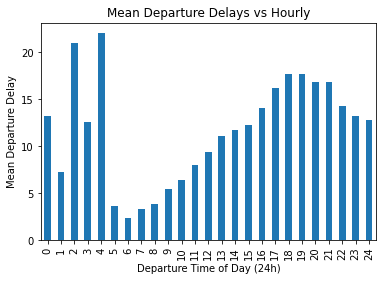

In [26]:
stats = pd.DataFrame(model_df['dep_delay'].groupby(model_df['crs_dep_time']).mean()).sort_values('dep_delay', ascending=False).reset_index()
stats.sort_values('crs_dep_time').plot.bar(x='crs_dep_time', y='dep_delay', ylabel='Mean Departure Delay', xlabel='Departure Time of Day (24h)', title='Mean Departure Delays vs Hourly', legend=False);
#plt.savefig('../images/departuretime_delay.png')

In [35]:
timeday_delay(model_df, 'dep_delay', 'crs_dep_time')

In [37]:
timeday_delay(model_df, 'dep_delay', 'crs_arr_time')